# G2++ Model Parameters Estimation Example

This notebook demonstrates how to calibrate the G2++ interest rate model using historical data.
We will use the `ir_models` package to estimate parameters for the ERB3M dataset.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import os

module_path = os.path.abspath(os.getcwd())
if module_path not in sys.path:
    sys.path.append(module_path)

from ir_models.estimation.g2pp import G2ppKalmanMLE

Loading data from data/ERB3M_historic.xlsx...
Data filtered from 2021-09-01 to 2024-08-31.
Number of observations: 36


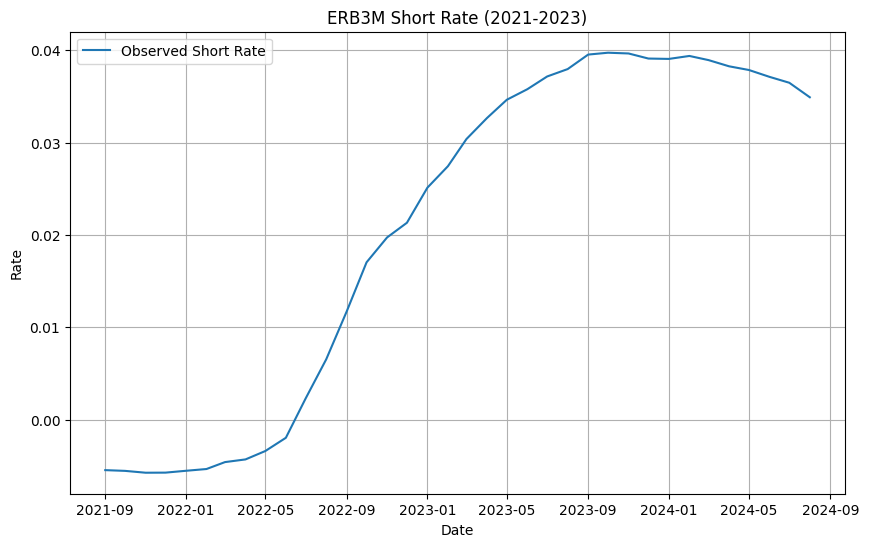

In [134]:
# Load data
file_path = 'data/ERB3M_historic.xlsx'
print(f"Loading data from {file_path}...")
df = pd.read_excel(file_path)

# Filter for 2021-2023 (3 years)
start_date = '2021-09-01'
end_date = '2024-08-31'

mask = (df['Date'] >= start_date) & (df['Date'] <= end_date)
df_filtered = df.loc[mask].copy()

# Sort by date ascending (oldest first)
df_filtered = df_filtered.sort_values('Date', ascending=True)

print(f"Data filtered from {start_date} to {end_date}.")
print(f"Number of observations: {len(df_filtered)}")

# Extract rates (Dernier column) and convert to decimal
rates = df_filtered['Dernier'].values / 100.0
dates = df_filtered['Date'].values

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(dates, rates, label='Observed Short Rate')
plt.title('ERB3M Short Rate (2021-2023)')
plt.xlabel('Date')
plt.ylabel('Rate')
plt.grid(True)
plt.legend()
plt.show()

In [135]:
# Define phi function
# We set phi(t) = 0 as we don't have any term structure to fit, assuming no deterministic shift for this example.
def phi_func(t):
    return 0.0

dt = 1.0 / 12.0  # Monthly data

**Reminder:**

Two-factor Gaussian (G2++) dynamics for the zero-mean factors $x,y$ used in the code:

$\displaystyle dx_t = -a\,x_t\,dt + \sigma\,dW_t^{(1)},$

$\displaystyle dy_t = -b\,y_t\,dt + \eta\,dW_t^{(2)},$

with $\mathrm{corr}(dW^{(1)},dW^{(2)})=\rho$. The short rate is assembled as

$\displaystyle r_t = x_t + y_t + \phi(t)$,

where $\phi(t)$ is a deterministic shift (used to fit the observed term structure).

In [136]:
# Initialize and run calibration
print("Parameter estimation of G2++ model...")

estimator = G2ppKalmanMLE(
    observations=rates,
    dt=dt,
    phi=phi_func,
    measurement_var=1e-6
)

# Initial guess (only for parameters to be estimated)
initial_guess = {
#    "a": 0.01,
#    "b": 0.50,
    "sigma": 0.09,
    "eta": 0.09,
    "rho": -0.5,
    "measurement_var": 1e-5,
}

# Fix mean reversion parameters
fixed_params = {
    "a": 0.01,  # 1% mean reversion for first factor
    "b": 0.50,  # 50% mean reversion for second factor
}

result = estimator.fit(initial_guess=initial_guess, fixed_params=fixed_params)

print("\nEstimation Results:")
print(f"Optimisation success: {result.optimized}")
print(f"Log-likelihood: {result.log_likelihood:.4f}")
print("Estimated Parameters:")
for key, value in result.params.items():
    print(f"  {key}: {value:.6f}")

Parameter estimation of G2++ model...

Estimation Results:
Optimisation success: True
Log-likelihood: 174.3964
Estimated Parameters:
  sigma: 0.013899
  eta: 0.013899
  rho: -0.922405
  measurement_var: 0.000000
  a: 0.010000
  b: 0.500000


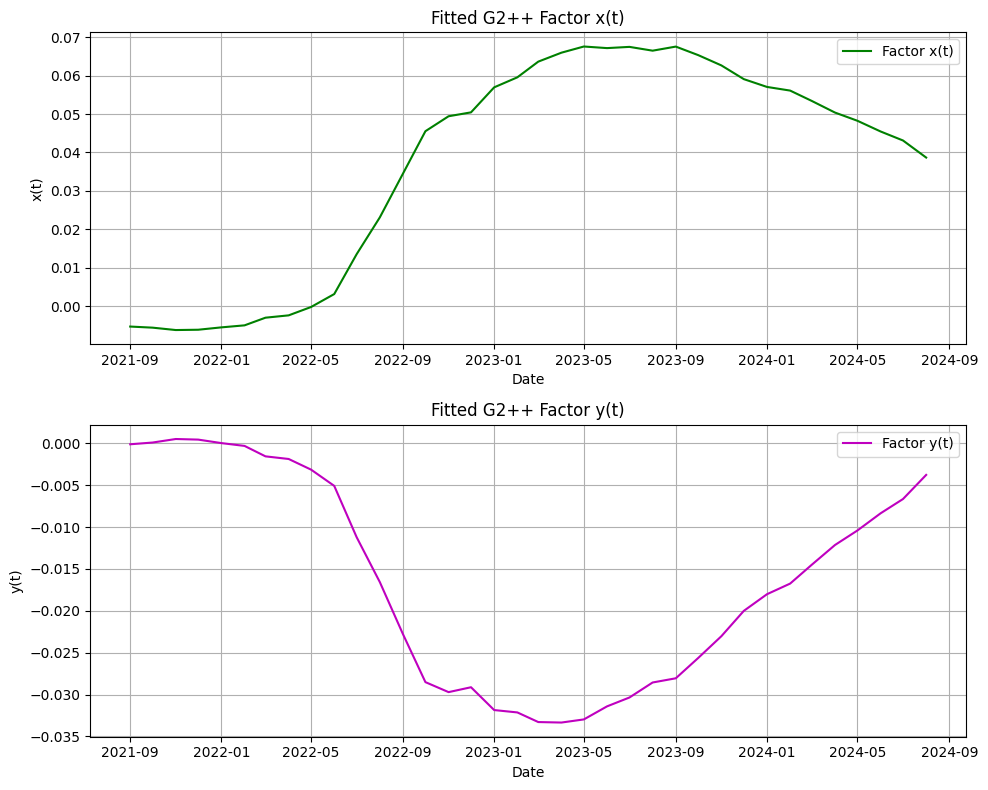

In [137]:
# Visualize the fitted factor states x(t) and y(t)
filtered_means = result.filtered_states
x_fitted = filtered_means[:, 0]
y_fitted = filtered_means[:, 1]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# Plot x factor
ax1.plot(dates, x_fitted, 'g-', label='Factor x(t)')
ax1.set_title('Fitted G2++ Factor x(t)')
ax1.set_xlabel('Date')
ax1.set_ylabel('x(t)')
ax1.grid(True)
ax1.legend()

# Plot y factor
ax2.plot(dates, y_fitted, 'm-', label='Factor y(t)')
ax2.set_title('Fitted G2++ Factor y(t)')
ax2.set_xlabel('Date')
ax2.set_ylabel('y(t)')
ax2.grid(True)
ax2.legend()

plt.tight_layout()
plt.show()

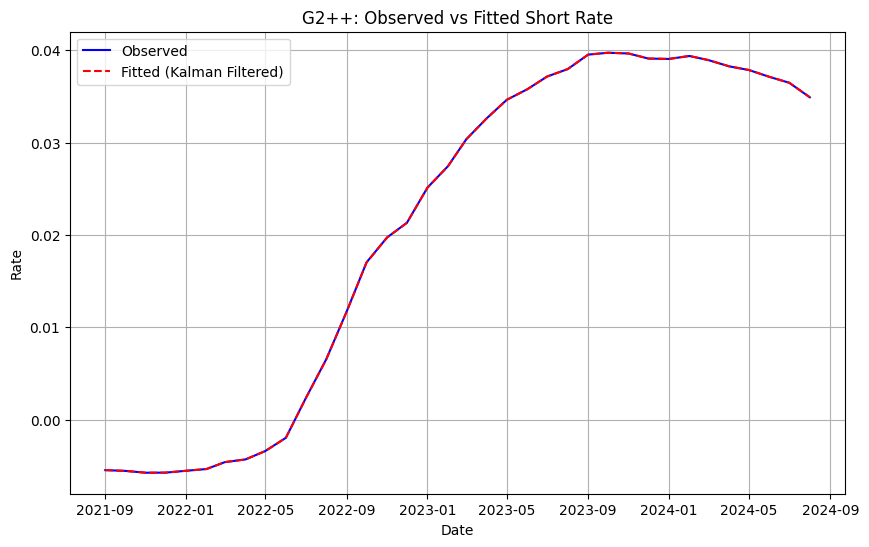

In [138]:
# Visualize fitted short rate vs observed
# Reconstruct the fitted short rate: r(t) = x(t) + y(t) + phi(t)

# Recompute phi on the grid
time_indices = np.arange(len(rates))
phi_values = np.array([phi_func(t * dt) for t in time_indices])

fitted_rates = x_fitted + y_fitted + phi_values

plt.figure(figsize=(10, 6))
plt.plot(dates, rates, 'b-', label='Observed')
plt.plot(dates, fitted_rates, 'r--', label='Fitted (Kalman Filtered)')
plt.title('G2++: Observed vs Fitted Short Rate')
plt.xlabel('Date')
plt.ylabel('Rate')
plt.legend()
plt.grid(True)
plt.show()